In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import math

In [31]:

train_data = datasets.CIFAR10(root="./data", download=True, train=True)
test_data = datasets.CIFAR10(root="./data", transform=transforms.ToTensor(), train=False)

Files already downloaded and verified


### Data augumentation

In [32]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels

  def __getitem__(self, index):
    return self.images[index], self.labels[index]
  
  def __len__(self):
    return len(self.labels)

In [1]:
def image_augumentation(dataset):
  transformed_images = []
  labels = []
  transform_list = [
      (transforms.RandomRotation(degrees=(0,180)), 5),
      (transforms.RandomHorizontalFlip(p=1), 1),
      (transforms.RandomVerticalFlip(p=1), 1),
      (transforms.ColorJitter(), 2),
      (transforms.RandomAffine(20), 2),
      (transforms.RandomPerspective(), 2),
      
  ]
  to_tensor = transforms.ToTensor()
  for i in range(len(train_data)):
    image, label = dataset[i]
    transformed_images.append(to_tensor(image))
    labels.append(label)
    # print(image)
    # transforms here
    for transform, count in transform_list:
      for _ in range(count):
        transformed_images.append(to_tensor(transform(image)))
        labels.append(label)
    print('done', i, "/", len(dataset))
  return transformed_images, labels

augumented_images = image_augumentation(train_data)
print(len(augumented_images))

In [34]:
# augumented_images = torch.load("drive/MyDrive/augumented_images.pt")
# len(augumented_images[1])

In [35]:
augument_dataset = ImageDataset(augumented_images[0], augumented_images[1])

In [36]:
train_data = ImageDataset(augumented_images[0], augumented_images[1])
test_image, test_target = train_data[-1]
test_image.size()

torch.Size([3, 32, 32])

In [37]:
len(train_data)

700000

In [38]:
print(torch.min(test_image), torch.max(test_image))

tensor(0.0157) tensor(1.)


In [39]:
def show_image(image):
  img = image.data.numpy()
  img = np.transpose(img, [1,2,0])
  plt.imshow(img)
  plt.show()

### Basic Convolution layer unit

In [40]:
class ConvLayer(nn.Module):

  def __init__(self, in_channels, out_channels, stride=1):
    super(ConvLayer, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.conv1 = nn.Conv2d(
        in_channels, 
        in_channels, 
        kernel_size=3, 
        stride=stride,
        padding=1,
        groups=in_channels
    )
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        stride=1,
    )
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    if x.size(2) > 3:
      x = torchvision.ops.drop_block2d(x, 0.3, block_size=3)
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    return x

In [41]:
conv_layer = ConvLayer(16, 32, 1)
x = torch.rand(10, 16, 32, 32)
out = conv_layer(x)
out.size()

torch.Size([10, 32, 32, 32])

### MobileNet Model

In [69]:
class MobileNet(nn.Module):

  def __init__(self):
    super(MobileNet, self).__init__()
    self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.bn = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.conv_layer1 = ConvLayer(64, 128, 1)
    self.conv_layer2 = ConvLayer(128, 128, 1)
    self.conv_layer3 = ConvLayer(128, 256, 2)
    self.conv_layer4 = ConvLayer(256, 256, 1)
    self.conv_layer5 = ConvLayer(256, 256, 1)
    self.conv_layer6 = ConvLayer(256, 256, 1)
    self.conv_layer7 = ConvLayer(256, 512, 2)
    self.conv_layer8 = ConvLayer(512, 512, 1)
    self.conv_layer9 = ConvLayer(512, 512, 1)
    self.conv_layer10 = ConvLayer(512, 512, 1)
    self.conv_layer11 = ConvLayer(512, 1024, 2)
    self.conv_layer12 = ConvLayer(1024, 1024, 1)
    self.conv_layer13 = ConvLayer(1024, 1024, 1)
    self.avg_pool = nn.AvgPool2d(4)
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(1024, 10)

  def forward(self, x):
    x = self.relu(self.bn(self.conv(x)))
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = self.conv_layer4(x)
    x = self.conv_layer5(x)
    x = self.conv_layer6(x)
    x = self.conv_layer7(x)
    x = self.conv_layer8(x)
    x = self.conv_layer9(x)
    x = self.conv_layer10(x)
    x = self.conv_layer11(x)
    x = self.conv_layer12(x)
    x = self.conv_layer13(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc(x)
    return x

In [70]:
sample_image = torch.rand(10, 3, 32, 32)
mobile_net = MobileNet()
out = mobile_net(sample_image)
out.size()

torch.Size([10, 10])

### Model Initialization

In [71]:
CUDA = torch.cuda.is_available()

In [97]:
model = MobileNet()
if CUDA:
  print(CUDA)
  model = model.cuda()

True


### Hyper parameters

In [98]:
# hyper parameters
learning_rate = 0.0005
decay_rate = 0.01
batch_size = 300
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [99]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

In [100]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [101]:
def epoch_train(model, num_epochs, epoch, data_loader, loss_fn, optimizer):
  CUDA = torch.cuda.is_available()
  model.train()
  sum_loss = 0
  sum_accuracy = 0
  iteration = 0
  total_count = 0
  for i, (images, targets) in enumerate(data_loader):
    if CUDA:
      images = images.cuda()
      targets = targets.cuda()
    outputs = model(images)
    _, predicted = torch.max(outputs, dim=1)
    if CUDA:
      sum_accuracy += (targets.cpu() == predicted.cpu()).sum()
    else:
      sum_accuracy += (targets == predicted).sum()
    loss = loss_fn(outputs, targets)
    sum_loss += loss.item() * len(targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    iteration += 1
    total_count += len(images)
    if i % 10 == 0:
      print('Epoch {}/{}, Iteration: {}/{}, Training loss: {:.3f}, Accuracy: {:.3f}'.format(
          epoch+1, num_epochs, i, len(data_loader), sum_loss / iteration, sum_accuracy / total_count
      ))
  train_losses.append(sum_loss / iteration)
  train_accuracy.append(sum_accuracy / total_count)

In [102]:
def epoch_test(model, num_epochs, epoch, data_loader, loss_fn):
  CUDA = torch.cuda.is_available()
  model.eval()
  with torch.no_grad():
    sum_loss = 0
    sum_accuracy = 0
    iteration = 0
    total_count = 0
    for i, (images, targets) in enumerate(data_loader):
      if CUDA:
        images = images.cuda()
        targets = targets.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)
      if CUDA:
        sum_accuracy += (targets.cpu() == predicted.cpu()).sum()
      else:
        sum_accuracy += (targets == predicted).sum()
      loss = loss_fn(outputs, targets)
      sum_loss += loss.item() * len(targets)
      iteration += 1
      total_count += len(images)
      print('Epoch {}/{}, Iteration: {}/{}, Test loss: {:.3f}, Accuracy: {:.3f}'.format(
          epoch+1, num_epochs, i, len(data_loader), sum_loss / iteration, sum_accuracy / total_count
      ))
    test_losses.append(sum_loss / iteration)
    test_accuracy.append(sum_accuracy / total_count)
    

In [103]:
def make_plot(train, test, train_label, test_label):
  fig = plt.figure(20)
  plt.plot(train, label=train_label)
  plt.plot(test, label=test_label)
  plt.legend()
  plt.show()

In [106]:
# optimizer.param_groups[0]['lr'] *= 0.1

In [2]:
# training loop
num_epochs = 10
for epoch in range(num_epochs):
  epoch_train(model, num_epochs, epoch, train_loader, loss_fn, optimizer)
  epoch_test(model, num_epochs, epoch, test_loader, loss_fn)
  torch.save(model.state_dict(), "./mini_mobile_net.pt")
  torch.save(train_losses, "./train_losses.pt")
  torch.save(test_losses, "./test_losses.pt")
  torch.save(train_accuracy, "./train_accuracy.pt")
  torch.save(test_accuracy, "./test_accuracy.pt")
  if epoch % 9 == 0:
    make_plot(train_losses, test_losses, "Train loss", "Test loss")
    make_plot(train_accuracy, test_accuracy, "Train accuracy","Test accuracy")
    

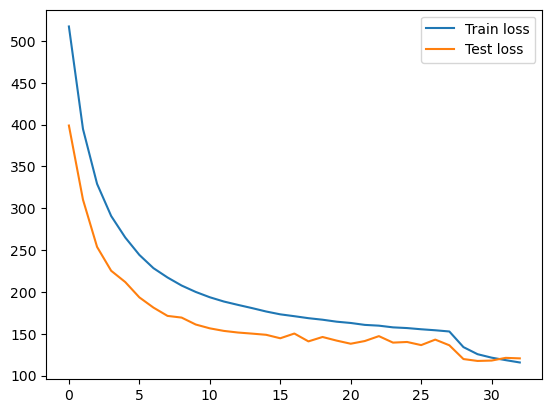

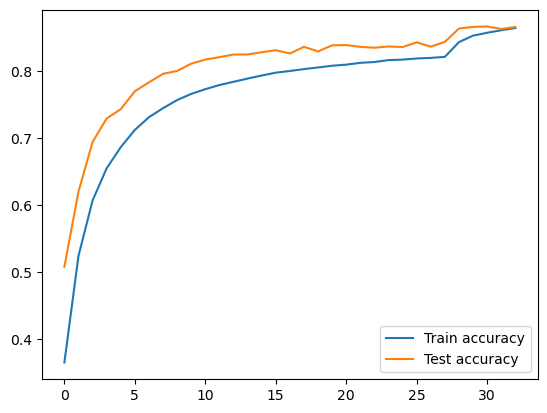

In [108]:
make_plot(train_losses, test_losses, "Train loss", "Test loss")
make_plot(train_accuracy, test_accuracy, "Train accuracy", "Test accuracy")